In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import  MinMaxScaler ,StandardScaler
import math
from sklearn.metrics import mean_squared_error ,accuracy_score
from pickle import dump, load
from math import sqrt
from tensorflow.keras.optimizers import SGD ,RMSprop
import datetime

In [4]:
col_names =['sl_no','iteration','r_meas','phi_meas','rr_meas','x_m','y_m','dx_m','dy_m','r_gd','phi_gd','rr_gd','x_gd','y_gd','dx_gd','dy_gd']

In [13]:
 df= pd.read_csv("data/training_data.csv",names=col_names,header=None)

In [14]:
df.head()

,sl_no,iteration,r_meas,phi_meas,rr_meas,x_m,y_m,dx_m,dy_m,r_gd,phi_gd,rr_gd,x_gd,y_gd,dx_gd,dy_gd
0,1,0,13.661716,0.006404,-0.176324,13.661436,0.087489,-0.176320,-0.001129,8.857460,0.000044,0.000746,8.857460,0.000391,0.000746,0.000000
1,1,1,18.462030,-0.017085,0.050058,18.459336,-0.315405,0.050051,-0.000855,8.825450,0.000429,-0.032009,8.825450,0.003786,-0.032009,-0.000014
2,1,2,6.413294,0.005260,0.005861,6.413205,0.033733,0.005861,0.000031,8.815560,0.001020,-0.009891,8.815555,0.008991,-0.009891,-0.000010
3,1,3,1.603305,-0.006222,0.035707,1.603274,-0.009976,0.035707,-0.000222,8.905530,0.001560,0.089970,8.905519,0.013895,0.089970,0.000140
4,1,4,7.389476,-0.015556,0.308614,7.388582,-0.114947,0.308577,-0.004801,9.140382,0.002096,0.234852,9.140361,0.019157,0.234851,0.000492


In [15]:
data = df[['x_m','y_m','x_gd','y_gd']]
data_input = data[['x_m','y_m']].values
data_input = data_input.reshape(-1,2)
data_gd = data[['x_gd','y_gd']].values
data_gd = data_gd.reshape(-1,2)

In [16]:
data_input.shape

(86254, 2)

In [17]:
#scaler_input_trail = MinMaxScaler()
#data_input_norm = scaler_input_trail.fit_transform(data_input)
#scaler_output_trail = MinMaxScaler()
#data_gd_norm = scaler_output_trail.fit_transform(data_gd)



In [18]:
def get_RMSE(predictions, ground_truth):
    x_rmse =sqrt(np.mean((predictions[:,0]-ground_truth[:,0])**2))
    y_rmse =sqrt(np.mean((predictions[:,1]-ground_truth[:,1])**2))
    return x_rmse,y_rmse
    

In [19]:
T=5
D=2
train_size = int(len(data_input)*0.75)

In [20]:
train_input , train_gd = data_input[:train_size] ,data_gd[:train_size]
print(f"training size input  {train_input.shape} , train size output {train_gd.shape}")

valid_input , valid_gd = data_input[train_size:] ,data_gd[train_size:]
print(f"test size input  {valid_input.shape} , test size output {valid_gd.shape}")



training size input  (64690, 2) , train size output (64690, 2)
test size input  (21564, 2) , test size output (21564, 2)


In [21]:
""" creates data sequences for input as well for the lables(output) 
    each row of this form isc created (x1,y1),(x2,y2),(x3.y3) --> (x_gd,y_gd)
    It contains the previous 3 measurements and ground truth of 4th element which is compared with prediction from model
""" 

def create_dataset(dataset_x,dataset_y,T):
    dataX, dataY = [], []
    for t in range(len(dataset_x)-T):
        x = dataset_x[t:t+T]
        dataX.append(x)
        dataY.append(dataset_y[t + T])
    return np.array(dataX), np.array(dataY)

In [22]:
train_input_seqs , train_gd_seq = create_dataset(train_input,train_gd,T)
valid_input_seqs , valid_gd_seq = create_dataset(valid_input,valid_gd,T)

train_input_seqs.shape

(64685, 5, 2)

adm =RMSprop(lr=0.001)
model_trail_u = Sequential()
model_trail_u.add(LSTM(16,input_shape=(T,2)))
model_trail_u.add(Dense(2))
model_trail_u.compile(loss ='mse',optimizer=adm)
rtu= model_trail_u.fit(train_input_seqs, train_gd_seq, epochs=200, batch_size = 32,verbose=2 ,validation_data=(valid_input_seqs,valid_gd_seq))


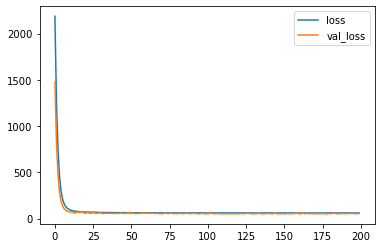

In [19]:
import matplotlib.pyplot as plt
plt.plot(rtu.history['loss'], label='loss')
plt.plot(rtu.history['val_loss'], label='val_loss')
plt.legend()

In [336]:
#dump(model,open('model.pkl','wb'))
model_trail_u.save("more_trail_u")


INFO:tensorflow:Assets written to: more_trail_u\assets


INFO:tensorflow:Assets written to: more_trail_u\assets


In [23]:
model_trail_u= load_model("more_trail_u")

In [24]:
trainPredict = model_trail_u.predict(train_input_seqs)
ValidPredict = model_trail_u.predict(valid_input_seqs)


In [25]:
trainScore = math.sqrt(mean_squared_error(train_gd_seq, trainPredict))
print('Train Score: %.7f RMSE' % (trainScore))
ValidScore = math.sqrt(mean_squared_error(valid_gd_seq, ValidPredict))
print('Test Score: %.7f RMSE' % (ValidScore))


Train Score: 7.7629827 RMSE
Test Score: 7.2901418 RMSE


In [26]:
# test data from same training file

In [27]:
df_TEST = pd.read_csv("data/testing_data.csv",names=col_names,header=None)

df_TEST.head()


,sl_no,iteration,r_meas,phi_meas,rr_meas,x_m,y_m,dx_m,dy_m,r_gd,phi_gd,rr_gd,x_gd,y_gd,dx_gd,dy_gd
0,1,0.0,118.557733,0.003044,0.255106,118.557184,0.360887,0.255105,0.000777,122.163476,0.000031,0.303078,122.163476,0.003750,0.303078,0.000009
1,1,1.0,120.571556,-0.003406,0.063379,120.570856,-0.410665,0.063379,-0.000216,122.204948,0.000288,0.041473,122.204943,0.035176,0.041473,0.000012
2,1,2.0,118.427954,-0.005077,-0.154127,118.426428,-0.601236,-0.154125,0.000782,122.027939,0.000666,-0.177010,122.027912,0.081260,-0.177010,-0.000118
3,1,3.0,121.466013,0.011516,-0.271541,121.457960,1.398717,-0.271523,-0.003127,121.755473,0.001147,-0.272466,121.755392,0.139696,-0.272466,-0.000313
4,1,4.0,125.982723,0.004073,-0.338679,125.981678,0.513099,-0.338677,-0.001379,121.501160,0.001774,-0.254313,121.500969,0.215603,-0.254312,-0.000451


In [28]:
df_TEST.shape

(101101, 16)

In [29]:
data_TEST = df_TEST[['x_m','y_m','x_gd','y_gd']]
data_input_TEST = data_TEST[['x_m','y_m']].values
data_input_TEST = data_input_TEST.reshape(-1,2)
data_gd_TEST = data_TEST[['x_gd','y_gd']].values
data_gd_TEST= data_gd_TEST.reshape(-1,2)
data_gd_TEST.shape 

(101101, 2)

In [30]:
TEST_input_seqs ,TEST_output_seqs = create_dataset(data_input_TEST,data_gd_TEST,T)

In [31]:
model_trail_u = load_model('more_trail_u')

In [32]:
predicts = model_trail_u.predict(TEST_input_seqs)

(96, 2)


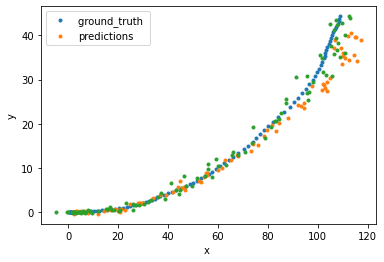

In [38]:
i=107
  
predict_b=predicts[(i*101):((i+1)*101)-T]

test_input_for_meas = data_input_TEST[(i*101)+T:(((i+1)*101))]
test_gd_for_meas_b = data_gd_TEST[(i*101)+T:(((i+1)*101))] 
print(test_gd_for_meas_b.shape)
rmse_p = math.sqrt(mean_squared_error(predict_b, test_gd_for_meas_b))
rmse_m = math.sqrt(mean_squared_error(test_input_for_meas,test_gd_for_meas_b))

plt.plot(test_gd_for_meas_b[:,0],test_gd_for_meas_b[:,1],'.')
plt.plot(predict_b[:,0],predict_b[:,1],'.')
plt.plot(test_input_for_meas[:,0],test_input_for_meas[:,1],'.')
plt.legend(["ground_truth ","predictions"])
plt.xlabel("x ")
plt.ylabel("y")
plt.savefig("Graph" + str(i)+" " + str(rmse_p) +" "+ str(rmse_m) +".png", format="PNG")
#plt.savefig("Graph" + str(i)+" " + str(rmse_p) +" "+ str(rmse_m) +".png", format="PNG")


In [33]:


for i in range(500,999):  
    predict_b=predicts[(i*101):((i+1)*101)-T]

    test_input_for_meas = data_input_TEST[(i*101)+T:(((i+1)*101))]
    test_gd_for_meas_b = data_gd_TEST[(i*101)+T:(((i+1)*101))] 
    
    rmse_p = math.sqrt(mean_squared_error(predict_b, test_gd_for_meas_b))
    rmse_m = math.sqrt(mean_squared_error(test_input_for_meas,test_gd_for_meas_b))

    plt.plot(test_gd_for_meas_b[:,0],test_gd_for_meas_b[:,1],'.')
    plt.plot(predict_b[:,0],predict_b[:,1],'.')
    plt.plot(test_input_for_meas[:,0],test_input_for_meas[:,1],'.')
    plt.legend(["ground_truth ","predictions","measurement"])
    plt.xlabel("x ")
    plt.ylabel("y")
    plt.savefig("Graph" + str(i)+" " + str(rmse_p) +" "+ str(rmse_m) +".png", format="PNG")
    plt.clf()


<Figure size 432x288 with 0 Axes>

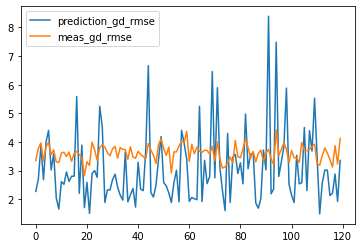

In [138]:

all_rmse_p =[]
all_rmse_m =[]

predicts = model_trail_u.predict(TEST_input_seqs)

for i in range(0,120):
    predict_b=predicts[(i*101):((i+1)*101)-T]
    test_input_for_meas = data_input_TEST[(i*101)+T:(((i+1)*101))]
    test_gd_for_meas_b = data_gd_TEST[(i*101)+T:(((i+1)*101))]    
    
    rmse_p = math.sqrt(mean_squared_error(predict_b, test_gd_for_meas_b))
    rmse_m = math.sqrt(mean_squared_error(test_input_for_meas,test_gd_for_meas_b))
    
                       
    all_rmse_p.append(rmse_p)
    all_rmse_m.append(rmse_m)
    
plt.plot(all_rmse_p)
plt.plot(all_rmse_m)
plt.legend(["prediction_gd_rmse","meas_gd_rmse"])

In [75]:
all_rmse_p_a = np.array(all_rmse_p)
all_rmse_m_a = np.array(all_rmse_m)


In [76]:
f=np.array((all_rmse_p_a-all_rmse_m_a)<0)

In [77]:
np.count_nonzero(f)

94

In [ ]:
##############################################################################

In [ ]:
################################################################################

In [ ]:
##################################################################################

In [57]:
###########################################################################test on different dataset 

In [118]:
df_TEST_diff = pd.read_csv("data/new/test_n_ml_next1L.csv",names=col_names,header=None)

df_TEST_diff.head()

,sl_no,iteration,r_meas,phi_meas,rr_meas,x_m,y_m,dx_m,dy_m,r_gd,phi_gd,rr_gd,x_gd,y_gd,dx_gd,dy_gd
0,1,0.0,118.557733,0.003044,0.255106,118.557184,0.360887,0.255105,0.000777,122.163476,0.000031,0.303078,122.163476,0.003750,0.303078,0.000009
1,1,1.0,120.571556,-0.003406,0.063379,120.570856,-0.410665,0.063379,-0.000216,122.204948,0.000288,0.041473,122.204943,0.035176,0.041473,0.000012
2,1,2.0,118.427954,-0.005077,-0.154127,118.426428,-0.601236,-0.154125,0.000782,122.027939,0.000666,-0.177010,122.027912,0.081260,-0.177010,-0.000118
3,1,3.0,121.466013,0.011516,-0.271541,121.457960,1.398717,-0.271523,-0.003127,121.755473,0.001147,-0.272466,121.755392,0.139696,-0.272466,-0.000313
4,1,4.0,125.982723,0.004073,-0.338679,125.981678,0.513099,-0.338677,-0.001379,121.501160,0.001774,-0.254313,121.500969,0.215603,-0.254312,-0.000451


In [119]:
df_TEST_diff.shape

(101101, 16)

In [120]:
data_TEST_diff = df_TEST_diff[['x_m','y_m','x_gd','y_gd']]
data_input_TEST_diff = data_TEST_diff[['x_m','y_m']].values
data_input_TEST_diff = data_input_TEST_diff.reshape(-1,2)
data_gd_TEST_diff = data_TEST_diff[['x_gd','y_gd']].values
data_gd_TEST_diff= data_gd_TEST_diff.reshape(-1,2)
data_gd_TEST_diff.shape                             

(101101, 2)

In [121]:
TEST_input_seqs_diff ,TEST_output_seqs_diff = create_dataset(data_input_TEST_diff,data_gd_TEST_diff,T)

In [134]:
predicts_diff = model_trail_u.predict(TEST_input_seqs_diff)

22 27 35 36  54 63   74 76 78 79 -lstm
26 46 51 55 58 62 65  67  69 70  75 112(50)-kf

rmse_p :14.053405455286228 
rmse_m:3.8946069102837506


Text(0, 0.5, 'y')

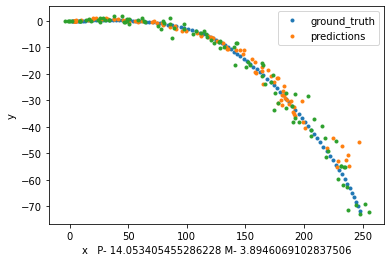

In [200]:
i=61



predict_diff_b=predicts_diff[(i*101):((i+1)*101)-T]
#np.savetxt('ml_predictions.csv',predict_diff_b,fmt ='%.7f',delimiter=',' )
test_input_for_meas = data_input_TEST_diff[(i*101)+T:(((i+1)*101))]
test_gd_for_meas_b = data_gd_TEST_diff[(i*101)+T:(((i+1)*101))] 

plt.plot(test_gd_for_meas_b[:,0],test_gd_for_meas_b[:,1],'.')
plt.plot(predict_diff_b[:,0],predict_diff_b[:,1],'.')
plt.plot(test_input_for_meas[:,0],test_input_for_meas[:,1],'.')
plt.legend(["ground_truth","predictions"])



rmse_p = math.sqrt(mean_squared_error(predict_diff_b, test_gd_for_meas_b))
print(f"rmse_p :{rmse_p} ")
rmse_m = math.sqrt(mean_squared_error(test_input_for_meas,test_gd_for_meas_b))
print(f"rmse_m:{rmse_m}")

plt.xlabel(f"x   P- {rmse_p} M- {rmse_m}")
plt.ylabel("y")

In [ ]:
predicts_diff = model_trail_u.predict(TEST_input_seqs_diff)

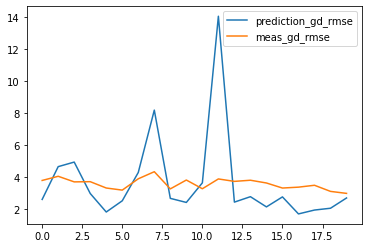

In [199]:

all_rmse_p =[]
all_rmse_m =[]



for i in range(50,70):
    predict_b_diff=predicts_diff[(i*101):((i+1)*101)-5]
    test_input_for_meas_diff = data_input_TEST_diff[(i*101)+5:(((i+1)*101))]
    test_gd_for_meas_diff_b = data_gd_TEST_diff[(i*101)+5:(((i+1)*101))]    
    
    rmse_p = math.sqrt(mean_squared_error(predict_b_diff, test_gd_for_meas_diff_b))
    rmse_m = math.sqrt(mean_squared_error(test_input_for_meas_diff,test_gd_for_meas_diff_b))
                       
    all_rmse_p.append(rmse_p)
    all_rmse_m.append(rmse_m)
    
plt.plot(all_rmse_p)
plt.plot(all_rmse_m)
plt.legend(["prediction_gd_rmse","meas_gd_rmse"])


In [124]:
all_rmse_p_a = np.array(all_rmse_p)
all_rmse_m_a = np.array(all_rmse_m)


In [139]:
f=np.array((all_rmse_p_a-all_rmse_m_a))
f

array([-9.98658980e-02, -1.81530972e+00, -8.71318112e-01, -5.80405064e-01,
       -1.95283868e+00, -3.96297013e-01,  2.40045294e-01,  2.80201840e-01,
       -1.61607393e+00, -6.68505682e-01,  9.61606736e-01, -6.66180327e-01,
       -4.13693755e-01, -1.29238430e+00, -6.81183511e-01, -7.32622476e-01,
       -4.14125872e-02, -1.76257760e+00, -1.24427200e-01, -1.48621280e+00,
        2.98936691e-01,  2.69765569e-01, -1.31055075e+00, -8.26483972e-01,
       -1.91754452e+00, -7.53365016e-01, -1.24556840e+00, -1.31679809e+00,
        4.12946505e+00, -1.68500572e+00, -2.41941929e+00, -1.27046495e-01,
       -1.90014375e+00, -7.85286627e-01,  4.70140401e-02, -8.31898556e-01,
       -6.74216365e-01, -1.55907057e+00, -1.48431349e+00, -1.46200814e+00,
       -1.75772554e+00, -4.72443478e-01, -7.77728805e-01, -1.83397770e+00,
       -1.32127287e+00,  2.69790447e-01, -9.51161042e-01,  3.58743686e-01,
        1.18464378e+00, -5.86177180e-02, -1.18479925e+00,  6.01657662e-01,
        1.23631604e+00, -

In [126]:
np.count_nonzero(f)

246

In [294]:
##### Second LSTM 

In [683]:
trainPredict.shape

(5097, 2)

In [684]:
first_three_predictions= data_gd[:3]

In [613]:
data_gd[:-3]

array([[ 3.8295941e+01,  1.9660000e-03],
       [ 3.8067063e+01,  7.9950000e-03],
       [ 3.8125018e+01,  1.4110000e-02],
       ...,
       [ 4.4056000e+00, -8.1401200e-01],
       [ 5.3884850e+00, -1.0222780e+00],
       [ 6.6605710e+00, -1.2958290e+00]])

In [614]:
all_pred_LSTM1 = np.concatenate((first_three_predictions,trainPredict_inv,ValidPredict_inv,testPredict_inv))
all_pred_LSTM1

array([[3.82959410e+01, 1.96600000e-03],
       [3.80670630e+01, 7.99500000e-03],
       [3.81250180e+01, 1.41100000e-02],
       ...,
       [3.24677467e+01, 1.38904095e+00],
       [3.46711769e+01, 1.44084072e+00],
       [3.59821129e+01, 1.46778965e+00]])

In [615]:
variance = (data_gd[:-3]-all_pred_LSTM1)**2


ValueError: operands could not be broadcast together with shapes (10198,2) (9698,2) 

In [387]:
def buildVarDataset(data_input,predict,variance_o):
    input_data=[]
    output_data=[]
    for t in range (len(data_input)-T):
        x = data_input[t:t+T,:].ravel()
        pred = predict[t]
        variance =  variance_o[t]
        row = np.concatenate((x,pred))
        input_data.append(row)
        output_data.append(variance)
    return input_data ,output_data


In [388]:
var_data_input , var_data_output = buildVarDataset(data_input,all_pred_LSTM1,variance)

In [389]:
var_data_input = np.array(var_data_input)
var_data_output = np.array(var_data_output)

In [390]:
var_data_input_scaler = MinMaxScaler()
var_data_input_scaled = var_data_input_scaler.fit_transform(var_data_input)

var_data_output_scaler = MinMaxScaler()
var_data_output_scaled =var_data_output_scaler.fit_transform(var_data_output)

In [391]:
train_size = int(len(var_data_input) //2)
test_size = len(var_data_input) - train_size

In [392]:
train_size

50003

In [393]:
var_train_input = var_data_input_scaled[:train_size]
var_train_output= var_data_output_scaled[:train_size]


var_valid_input = var_data_input_scaled[train_size: (train_size+test_size//2)]
var_valid_output = var_data_output_scaled[train_size: (train_size+test_size//2)]
                                                      
var_test_input = var_data_input_scaled[(train_size+test_size//2):]                                          
var_test_output = var_data_output_scaled[(train_size+test_size//2):]   
var_train_input

array([[0.72902007, 0.49616563, 0.72903333, ..., 0.50287227, 0.70637079,
        0.49898303],
       [0.72903333, 0.49794973, 0.72904047, ..., 0.50034592, 0.70637096,
        0.49908738],
       [0.72904047, 0.50287227, 0.72904866, ..., 0.50032555, 0.70637092,
        0.49921848],
       ...,
       [0.49694259, 0.44036342, 0.47919632, ..., 0.45354273, 0.4767777 ,
        0.4349927 ],
       [0.47919632, 0.44440117, 0.46351878, ..., 0.4669142 , 0.45645874,
        0.44003326],
       [0.46351878, 0.45354273, 0.45137357, ..., 0.48299939, 0.44037442,
        0.44891178]])

In [394]:
var_train_input = np.reshape(var_train_input,(var_train_input.shape[0],4,2))
var_valid_input = np.reshape(var_valid_input,(var_valid_input.shape[0],4,2))
var_test_input = np.reshape(var_test_input,(var_test_input.shape[0],4,2))

In [403]:
var_model = Sequential()
var_model.add(LSTM(8,input_shape=(4,2)))
var_model.add(Dense(2))
var_model.compile(loss ='mse',optimizer='adam')
rvar= var_model.fit(var_train_input, var_train_output, epochs=20, batch_size = 120 ,verbose=2 ,validation_data=(var_valid_input,var_valid_output))

Epoch 1/20
417/417 - 4s - loss: 6.6757e-04 - val_loss: 0.0012
Epoch 2/20
417/417 - 1s - loss: 2.0413e-05 - val_loss: 0.0012
Epoch 3/20
417/417 - 1s - loss: 1.2537e-05 - val_loss: 0.0011
Epoch 4/20
417/417 - 1s - loss: 1.2174e-05 - val_loss: 0.0011
Epoch 5/20
417/417 - 1s - loss: 1.1971e-05 - val_loss: 0.0011
Epoch 6/20
417/417 - 1s - loss: 1.1714e-05 - val_loss: 0.0011
Epoch 7/20
417/417 - 1s - loss: 1.1440e-05 - val_loss: 0.0011
Epoch 8/20
417/417 - 1s - loss: 1.1157e-05 - val_loss: 0.0011
Epoch 9/20
417/417 - 1s - loss: 1.0888e-05 - val_loss: 0.0011
Epoch 10/20
417/417 - 1s - loss: 1.0602e-05 - val_loss: 0.0011
Epoch 11/20
417/417 - 1s - loss: 1.0316e-05 - val_loss: 0.0011
Epoch 12/20
417/417 - 1s - loss: 1.0167e-05 - val_loss: 0.0011
Epoch 13/20
417/417 - 1s - loss: 9.9624e-06 - val_loss: 0.0011
Epoch 14/20
417/417 - 1s - loss: 9.8143e-06 - val_loss: 0.0011
Epoch 15/20
417/417 - 1s - loss: 9.6816e-06 - val_loss: 0.0011
Epoch 16/20
417/417 - 1s - loss: 9.6221e-06 - val_loss: 0.0011
E

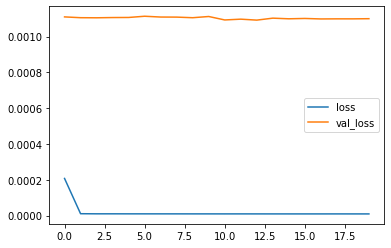

In [396]:
import matplotlib.pyplot as plt
plt.plot(rvar.history['loss'], label='loss')
plt.plot(rvar.history['val_loss'], label='val_loss')
plt.legend()

In [397]:
var_test_predict = var_model.predict(var_test_input)
var_valid_predict = var_model.predict(var_valid_input)
var_train_predict = var_model.predict(var_train_input)

In [398]:
var_train_predict_inv = var_data_output_scaler.inverse_transform(var_train_predict)
var_train_output_inv = var_data_output_scaler.inverse_transform(var_train_output)


var_test_predict_inv = var_data_output_scaler.inverse_transform(var_test_predict)
var_test_output_inv = var_data_output_scaler.inverse_transform(var_test_output)

In [399]:


trainScore = math.sqrt(mean_squared_error(var_train_predict_inv, var_train_output_inv))
print('Train Score: %.7f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(var_test_predict_inv, var_test_output_inv))
print('Test Score: %.7f RMSE' % (testScore))

Train Score: 180451753.1916904 RMSE
Test Score: 3515456736.8155990 RMSE


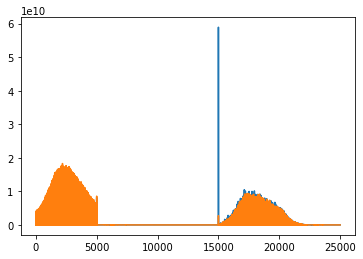

In [400]:
plt.plot(var_test_output_inv)

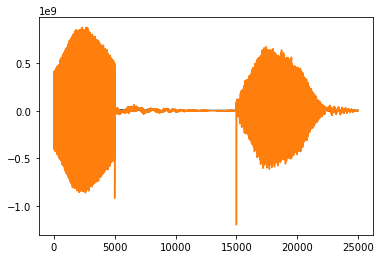

In [401]:
plt.plot(var_test_predict_inv)

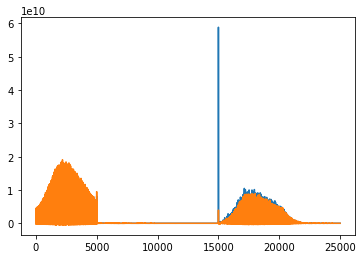

In [402]:
plt.plot(var_test_output_inv-var_test_predict_inv)